In [1]:
#@title **Installing libraries**
%%capture
! sudo apt update
! sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
%pip install chempy
%pip install -q ipywidgets

### **Extrapolating the value of $\Delta G^0$ at different temperatures using two approximations**

\begin{equation}
 \Delta G_1^{\circ}(T)= \Delta G^{\circ}(T_{ref})+4\Delta \nu RT \left(1-\Theta+\ln \Theta\right) \tag{1}
\end{equation}
with $\Theta=T/T_{ref}$ and $T=298.15$ K. For temperatures not very very far from $298.15$ $\mathrm{K}$, a second order Taylor polynomial for $\ln \Theta$ provides the following result for the standard Gibbs energy of reaction:
\begin{equation}
 \Delta G_2^{\circ}(T) = \Delta G^{\circ}(298.15)-2\Delta \nu RT (\Theta-1)^2 \tag{2}
\end{equation}


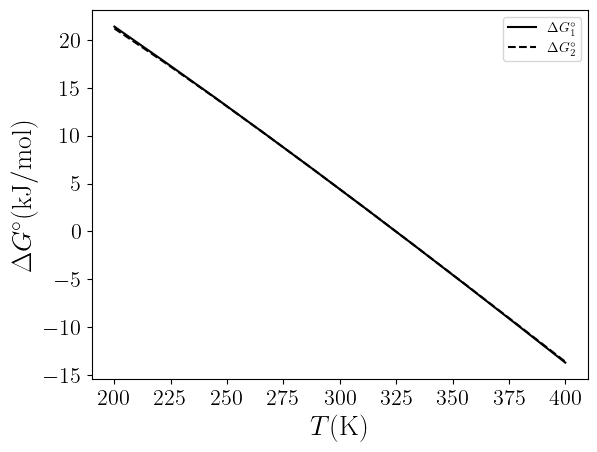

In [2]:
#@title Comparison of $\Delta G^{\circ}(T)$ calculated according to eqs 1 and 2. The user must provide $\Delta H^{\circ}(298.15)$ and $\Delta S^{\circ}(298.15)$ in KJ/mol and $\Delta \nu$.
# Defining some constants
m_u    = 1.66053886e-27      # atomic mass constant in kg
h      = 6.6260693e-34       # Planck's constant in J*s
k_B    = 1.3806505e-23       # Boltzmann's constant in J/K
c      = 2.99792558e8        # Speed of light in m/s
bar2Pa = 1e5                 # 1 bar to N/m**2
Pa2bar = 1e-5                # 1 Pa=N/m**2 to bar
p0     = 1                   # standard pressure in bar
R      = 8.31447e-3          # Gas constant in kJ/(K mol)
H2kcal = 627.509             # Hartree to kcal/mol
H2kJ   = 2625.5              # Hartree to kJ/mol
Rbar   = 0.0831447           # R in bar L / (mol K)
Rkcal  = 1.9872036e-3        # R in kcal mol-1 K-1

import numpy as np
import matplotlib.pyplot as plt

def deltaG1_T(DH0,DS0,delta_nu,T):
  theta = 298.15 / T
  return DH0 - T * DS0 +  4 * delta_nu * R * T * ( 1 - theta + np.log(theta))

def deltaG2_T(DH0,DS0,delta_nu,T):
  theta = 298.15 / T
  return DH0 - T * DS0 - 2 * delta_nu * R * T * (theta - 1) ** 2

DH0 = 57.12
DS0 = 0.1757
delta_nu = 1

T = np.linspace(200,400,10)

plt.rcParams['text.usetex'] = True


plt.plot(T,deltaG1_T(DH0,DS0,delta_nu,T),color='black',label='$\Delta G^{\circ}_1$')
plt.plot(T,deltaG2_T(DH0,DS0,delta_nu,T),'--',color='black',label='$\Delta G^{\circ}_2$')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('$\Delta G^{\circ} (\mathrm{kJ/mol})$',fontsize=20)
plt.xlabel('$T (\mathrm{K})$',fontsize=20)
plt.legend()
plt.savefig("deltaG.svg",bbox_inches='tight')

plt.show()

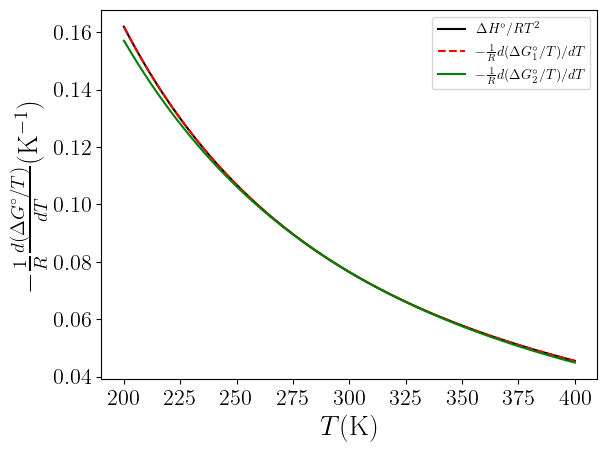

In [4]:
#@title Test of van't Hoff equation using both approximations to $\Delta G^{\circ}(T)$ (eqs 1 and 2)

T = np.linspace(200,400,1000)

deltaHoverRT2 = DH0 / (R * T ** 2) + 4 * delta_nu * (T - 298.15) / T ** 2
lnkp1 = - deltaG1_T(DH0,DS0,delta_nu,T) / R / T
lnkp2 = - deltaG2_T(DH0,DS0,delta_nu,T) / R / T

slope1 = np.gradient(lnkp1,T)
slope2 = np.gradient(lnkp2,T)
plt.plot(T,deltaHoverRT2,'-',color='black',label=r'$\Delta H^{\circ}/RT^2$')
plt.plot(T,slope1,'--',color='red',label=r'$-\frac{1}{R}d(\Delta G_1^{\circ}/T)/dT $')
plt.plot(T,slope2,'-',color='green',label=r'$-\frac{1}{R}d(\Delta G_2^{\circ}/T)/dT $')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel(r'$-\frac{1}{R}\frac{d(\Delta G^{\circ}/T)}{dT} (\mathrm{K}^{-1})$',fontsize=20)
plt.xlabel(r'$T (\mathrm{K})$',fontsize=20)
plt.legend()
plt.savefig('vanhoff.svg',bbox_inches='tight')
plt.show()

### **Working with an example reaction $0→\nu_iA_i$ conducted at constant $p$ and $T$**


In [5]:
#@title To input your chemical rxn, use blank spaces to separate stochiometric coeffs, species and arrow, like in this example: A + B -> 2 C + 3 D
%matplotlib inline

from ipywidgets import interactive, FloatSlider, IntSlider
from chempy.chemistry import Species, Equilibrium, Reaction
from chempy import Substance
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown, display


r = Reaction.from_string(input("Input your chemical reaction here:  "))
eq = Equilibrium(r.reac, r.prod)

display(Markdown("**REACTION CONDUCTED AT CONSTANT _p_ AND _T_**"))

#Obtain the stoichiometric coefficients and the species from the rxn
nui_from_r = []; species = []; ni0_from_r = []
for s in r.reac:
  species.append(s)
  nui_from_r.append(-r.reac[s])
  ni0_from_r.append(r.reac[s])
for s in r.prod:
  species.append(s)
  nui_from_r.append(r.prod[s])
  ni0_from_r.append(0)
for s in r.reac:
  print('Initial number of moles of %3s = %5.3f mol' % (s,r.reac[s] ))
for s in r.prod:
  print('Initial number of moles of %3s = %5.3f mol' % (s,0 ))

fake_keys = ['H2O','H2']
subst = {k: Substance.from_formula(k) for k in fake_keys}
eq_unicode=eq.unicode(subst)
eq_latex='$'+eq.latex(subst)+'$'

# T = 298.15 K (can be changed with the slider). DH0 and DS0 should be input
T = 298.15
# These values are taken from the N2O4 decomposition example below
#DH0 = 54.407
#DS0 = 0.167

#DG0 = deltaG_T(DH0,DS0,sum(nui_from_r),T)
#n_species taken from the length of the nui_from_r
n_species = len(nui_from_r)
#nui is an array with the stochiometric coeffs
nui = np.array(nui_from_r)
#ni0 is an array with the initial number of moles. For nice-looking graphs, we make the number of moles equal to the corresponding stochiometric coeffs for reactatns: n_i = nui_i
ni0 = np.array(ni0_from_r)
print
#max(ni0) has to be changed if a limiting reactant exists
x = np.linspace(1e-10,max(ni0)-1e-10,num=10000)
#n is the total number of moles and xi is the molar fraction
n = sum(ni0) + sum(nui) * x


Vol0 = sum(ni0) * Rbar * T
print('Initial volume = %5.3f L' % (Vol0))

xi = []
for k,ele in enumerate(ni0):
  xi.append((ni0[k] + x * nui[k]) / n)
xia = np.array(xi)
print('\n',eq_unicode,'EQUILIBRIUM PROPERTIES')


plt.rcParams['text.usetex'] = True

def f(p,T):
    # We use here the first approx. (eq 28) that fulfills van't Hoff eq. Eq 29 does not (I believe, check this!!!)
    deltaG0 = deltaG1_T(DH0,DS0,sum(nui),T)
    #mui0 are the standard chemical potentials of the species (kJ/mol)
    mui0_from_r = []
    #G of the reacts is 0 and for the products is shared equally
    G_per_prod = deltaG0 / len(r.prod)
    for i in range(len(r.reac)):
      mui0_from_r.append(0)
    for s in r.prod:
      mui0_from_r.append(G_per_prod/r.prod[s])

    mui0 = np.array(mui0_from_r)
    print(mui0)
    print(nui)
    #muistar is the chemical potential for the pure species = mui0+RTln(p/p0)
    k_p = np.exp(-deltaG0/R/T)
    print('Kp from stantard Gibbs energy of rxn = %5.3f' % k_p)
    plt.figure(2)
    muistar = mui0 + R * T * np.log(p/p0)
    G_star = 1 / R / T * ( sum(ni0 * muistar) + x * sum(nui * muistar) )
    G_mix  = n * sum(xia * np.log(xia))
    G = G_star + G_mix
    y = np.zeros(x.size)
    x_eq = x[np.argmin(G)]
    n_eq = sum(ni0) + sum(nui) * x_eq
    p_eq = []
    Vol = n_eq * Rbar * T / p
    print('Extent of rxn = %5.3f mol' % x_eq )
    print('Total number of moles = %5.3f mol' % (n_eq))
    print('Volume = %5.3f L' % (Vol))
    for k,ele in enumerate(ni0): print('Moles of %a = %5.3f mol' % (species[k],ele+x_eq * nui[k]))
    k_from_peq = 1
    for k,ele in enumerate(ni0):
      p_eq.append((ele+x_eq * nui[k])/n_eq * p )
      print('Partial pressure of %a = %5.3f bar' % (species[k],p_eq[k]))
      k_from_peq *= p_eq[k] ** nui[k]
    print('kp from the partial pressures %5.3f' % k_from_peq)
    #plt.title(eq_latex,fontsize=20)
    plt.plot(x,G_star,'-',color='blue',label=r'$(G^*(0)+\xi\Delta G^*)/RT$')
    #plt.plot(x,G_star,':',color='blue',label=r'$\frac{1}{RT}\left(\sum_i n_i(0)\mu_i^*+\xi\sum_i\nu_i\mu_i^*\right)$')
    plt.plot(x,G_mix,'-',color='red',label=r'$\Delta _{mix}G/RT$')
    plt.plot(x,G,'-',color='black',label=r'$G/RT$')
    #plt.plot(x,y,':',color='black')
    plt.grid(linestyle='dotted')
    plt.legend()
    plt.xlim(0,max(x))
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel(r'$G/RT (\mathrm{mol})$',fontsize=20)
    plt.xlabel(r'$\xi (\mathrm{mol})$',fontsize=20)
    plt.savefig('G.svg',bbox_inches='tight')
    plt.show()

interactive_plot = interactive(f, p=FloatSlider(value=1, min=0.1, max=10.0, step=0.1, description='p(bar):'), T=FloatSlider(value=298.15, min=200.15, max=400.15, step=1.00, description='T(K):'))
output = interactive_plot.children[-1]
output.layout.height = '800px'
interactive_plot

Input your chemical reaction here:  A -> 2 B


**REACTION CONDUCTED AT CONSTANT _p_ AND _T_**

Initial number of moles of   A = 1.000 mol
Initial number of moles of   B = 0.000 mol
Initial volume = 24.790 L

 A ⇌ 2 B EQUILIBRIUM PROPERTIES


interactive(children=(FloatSlider(value=1.0, description='p(bar):', max=10.0, min=0.1), FloatSlider(value=298.…

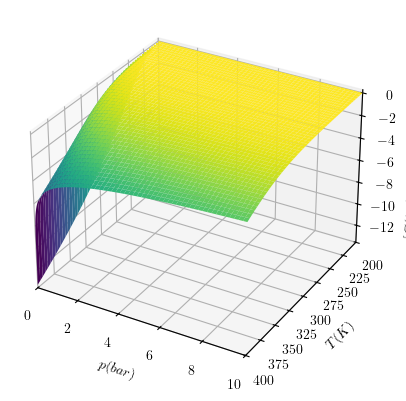

In [6]:
#@title Dependence of $G/RT$ on $p$ and $T$
%matplotlib inline

from ipywidgets import interactive, FloatSlider, IntSlider
from chempy.chemistry import Species, Equilibrium, Reaction
from chempy import Substance
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown, display


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

def G_pt(p,T):
    # We use here the first approx. (eq 28) that fulfills van't Hoff eq. Eq 29 does not (I believe, check this!!!)
    deltaG0 = deltaG1_T(DH0,DS0,sum(nui),T)
    k_p = np.exp(-deltaG0/R/T)
    xi = np.sqrt(k_p / (k_p + 4 * p))

    nui1= -1
    nui2 = 2
    ni01 = 1
    ni02 = 0
    mui01 = 0
    mui02 = deltaG0/2
    #muistar is the chemical potential for the pure species = mui0+RTln(p/p0)
    muistar1 = mui01 + R * T * np.log(p/p0)
    muistar2 = mui02 + R * T * np.log(p/p0)

    G_star0 = 1 / R / T * ( ni01 * muistar1 + ni02 * muistar2 )
    G_star = 1 / R / T * ( ni01 * muistar1 + ni02 * muistar2 + xi * (nui1 * muistar1 + nui2 * muistar2) )

    n = sum(ni0) + sum(nui) * xi
    xia0 = []
    for k,ele in enumerate(ni0):
      xia0.append((ni0[k] + xi * nui[k]) / n)
    xia = np.array(xia0)

    G_mix  = n * sum(xia * np.log(xia))
    G = G_star + G_mix

    return G - G_star0

#print(G_pt(1,298.15))

p = np.linspace(0.0001,10,1000)
T = np.linspace(200,400,1000)
p, T = np.meshgrid(p, T)
Z = G_pt(p, T)


# Plot the surface.
#ax.plot_surface(p, T, Z, cmap=plt.cm.YlGnBu_r)
ax.plot_surface(p, T, Z, cmap=plt.cm.viridis)

# Tweak the limits and add latex math labels.
#ax.set_zlim(0, 1)
ax.set_xlim(0,10)
ax.set_ylim(400,200)

ax.set_xlabel(r'$p \mathrm(bar)$')
ax.set_ylabel(r'$T \mathrm(K)$')
ax.set_zlabel(r'$\left[G(\xi_{eq})-G(0)\right]/RT \mathrm{(mol)}$')
#ax.contour(p, T, Z, zdir='z', offset=-12, colors='k', levels=[-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2],linestyles='-')


plt.savefig('3D_G.svg',bbox_inches='tight')

plt.show()


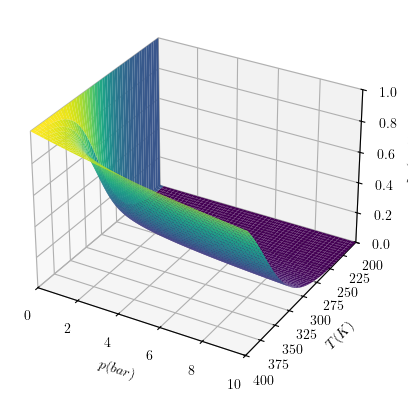

In [7]:
#@title Dependence of $\xi_{eq}$ on $p$ and $T$
%matplotlib inline

from ipywidgets import interactive, FloatSlider, IntSlider
from chempy.chemistry import Species, Equilibrium, Reaction
from chempy import Substance
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown, display


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

def xi_pt(p,T):
    # We use here the first approx. (eq 28) that fulfills van't Hoff eq. Eq 29 does not (I believe, check this!!!)
    deltaG0 = deltaG1_T(DH0,DS0,sum(nui),T)
    k_p = np.exp(-deltaG0/R/T)
    xi = np.sqrt(k_p / (k_p + 4 * p))
    return xi


p = np.linspace(0,10,1000)
T = np.linspace(200,400,1000)
p, T = np.meshgrid(p, T)
Z = xi_pt(p, T)


# Plot the surface.
ax.plot_surface(p, T, Z, cmap=plt.cm.viridis)

# Tweak the limits and add latex math labels.
ax.set_zlim(0, 1)
ax.set_xlim(0,10)
ax.set_ylim(400,200)
ax.set_xlabel(r'$p \mathrm(bar)$')
ax.set_ylabel(r'$T \mathrm(K)$')
ax.set_zlabel(r'$\xi_{eq} \mathrm{(mol)}$')

plt.savefig('3D_xi.svg',bbox_inches='tight')

plt.show()


### **Working with an example reaction $0→\nu_iA_i$ conducted at constant $V$ and $T$**


In [8]:
#@title To input your chemical rxn, use blank spaces to separate stochiometric coeffs, species and arrow, like in this example: A + B -> 2 C + 3 D
%matplotlib inline

from ipywidgets import interactive, FloatSlider, IntSlider
from chempy.chemistry import Species, Equilibrium, Reaction
from chempy import Substance
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown, display


r = Reaction.from_string(input("Input your chemical reaction here:  "))
eq = Equilibrium(r.reac, r.prod)

display(Markdown("**REACTION CONDUCTED AT CONSTANT _V_ AND _T_**"))

#Obtain the stoichiometric coefficients and the species from the rxn
nui_from_r = []; species = []; ni0_from_r = []
for s in r.reac:
  species.append(s)
  nui_from_r.append(-r.reac[s])
  ni0_from_r.append(r.reac[s])
for s in r.prod:
  species.append(s)
  nui_from_r.append(r.prod[s])
  ni0_from_r.append(0)
for s in r.reac:
  print('Initial number of moles of %3s = %5.3f mol' % (s,r.reac[s] ))
for s in r.prod:
  print('Initial number of moles of %3s = %5.3f mol' % (s,0 ))

fake_keys = ['H2O','H2']
subst = {k: Substance.from_formula(k) for k in fake_keys}
eq_unicode=eq.unicode(subst)
eq_latex='$'+eq.latex(subst)+'$'

# T = 298.15 K (can be changed with the slider). DH0 and DS0 should be input
T = 298.15
# These values are taken from the N2O4 decomposition example below
#DH0 = 54.407
#DS0 = 0.167
#DG0 = deltaG_T(DH0,DS0,sum(nui_from_r),T)
#n_species taken from the length of the nui_from_r
n_species = len(nui_from_r)
#nui is an array with the stochiometric coeffs
nui = np.array(nui_from_r)
#ni0 is an array with the initial number of moles. For nice-looking graphs, we make the number of moles equal to the corresponding stochiometric coeffs for reactatns: n_i = nui_i
ni0 = np.array(ni0_from_r)
print
#max(ni0) has to be changed if a limiting reactant exists
x = np.linspace(1e-10,max(ni0)-1e-10,num=10000)
#n is the total number of moles and xi is the molar fraction
n = sum(ni0) + sum(nui) * x


Vol0 = sum(ni0) * Rbar * T
p = sum(ni0) * Rbar * T / Vol0
print('Initial pressure = %5.3f bar' % (p))

xi = []
for k,ele in enumerate(ni0):
  xi.append((ni0[k] + x * nui[k]) / n)
xia = np.array(xi)
print('\n',eq_unicode,'EQUILIBRIUM PROPERTIES')


plt.rcParams['text.usetex'] = True

def f(V,T):
    # We use here the first approx. (eq 28) that fulfills van't Hoff eq. Eq 29 does not (I believe, check this!!!)
    deltaG0 = deltaG1_T(DH0,DS0,sum(nui),T)
    #mui0 are the standard chemical potentials of the species (kJ/mol)
    mui0_from_r = []
    #G of the reacts is 0 and for the products is shared equally
    G_per_prod = deltaG0 / len(r.prod)
    for i in range(len(r.reac)):
      mui0_from_r.append(0)
    for s in r.prod:
      mui0_from_r.append(G_per_prod/r.prod[s])

    mui0 = np.array(mui0_from_r)
    #muistar is the chemical potential for the pure species = mui0+RTln(p/p0)
    k_p = np.exp(-deltaG0/R/T)
    print('Kp from stantard Gibbs energy of rxn = %5.3f' % k_p)
    plt.figure(2)
    p = n * Rbar * T / V

    print(mui0)
    print(ni0,sum(ni0))
    print(nui,sum(nui))

    muistar = R * T * np.log(p/p0)
    G_star = 1 / R / T * ( sum(ni0 * mui0) + muistar*sum(ni0) + x * (sum(nui * mui0) + sum(nui)*muistar) )

    G_mix  = n * sum(xia * np.log(xia))
    A = G_star + G_mix -n
    y = np.zeros(x.size)
    x_eq = x[np.argmin(A)]
    n_eq = sum(ni0) + sum(nui) * x_eq
    peq = n_eq * Rbar * T / V
    p_eq = []
    print('Extent of rxn = %5.3f mol' % x_eq )
    print('Total number of moles = %5.3f mol' % (n_eq))
    print('Pressure = %5.3f bar' % (peq))
    for k,ele in enumerate(ni0): print('Moles of %a = %5.3f mol' % (species[k],ele+x_eq * nui[k]))
    k_from_peq = 1
    #for k,ele in enumerate(ni0):
    #  p_eq.append((ele+x_eq * nui[k])/n_eq * p )
    #  print('Partial pressure of %a = %5.3f bar' % (species[k],p_eq[k]))
    #  k_from_peq *= p_eq[k] ** nui[k]
    #print('kp from the partial pressures %5.3f' % k_from_peq)
    #plt.title(eq_latex,fontsize=20)
    plt.plot(x,G_star,'-',color='blue',label=r'$\frac{1}{RT}\left(\sum_i n_i(0)\mu_i^*+\xi\sum_i\nu_i\mu_i^*\right)$')
    plt.plot(x,-n,'-',color='green',label=r'$-n$')
    plt.plot(x,G_mix,'-',color='red',label=r'$\Delta _{mix}G/RT$')
    plt.plot(x,A,'-',color='black',label=r'$A/RT$')
    #plt.plot(x,y,':',color='black')
    plt.grid(linestyle='dotted')
    plt.legend()
    plt.xlim(0,max(x))
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel(r'$A/RT (\mathrm{mol})$',fontsize=20)
    plt.xlabel(r'$\xi (\mathrm{mol})$',fontsize=20)
    plt.savefig('A.svg',bbox_inches='tight')
    plt.show()

interactive_plot = interactive(f, V=FloatSlider(value=24.8, min=2, max=250.0, step=0.1, description='V(L):'), T=FloatSlider(value=298.15, min=200.15, max=400.15, step=1.00, description='T(K):'))
output = interactive_plot.children[-1]
output.layout.height = '800px'
interactive_plot

Input your chemical reaction here:  A -> 2 B


**REACTION CONDUCTED AT CONSTANT _V_ AND _T_**

Initial number of moles of   A = 1.000 mol
Initial number of moles of   B = 0.000 mol
Initial pressure = 1.000 bar

 A ⇌ 2 B EQUILIBRIUM PROPERTIES


interactive(children=(FloatSlider(value=24.8, description='V(L):', max=250.0, min=2.0), FloatSlider(value=298.…

**Comments:**

In the above figure, the slope of the blue line is $=-\ln K_x$

Van't Hoff equation (that assumes a temperature-independent $\Delta H^0$) could be compared with our results in a separate figure